**[Assignment#3 Breast Ultrasound Images Dataset에 U-Net 적용]**

Breast Ultrasound Images Dataset(https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code) 데이터셋에서 U-Net을 이용해 유방암 병변 분할하는 코드를 작성하시오.
코드 작성 내용
1.	U-Net 을 이용한 유방암 병변 분할
2.	모델 평가 (Dice Score 혹은 IoU 중 택 1)
3.	원본, Ground Truth 마스크, 모델 분할 결과 예시(1건 이상) 출력

In [1]:
# Core
import pandas as pd
import numpy as np
import os
import cv2 #이미지를 읽어와서 표현 etc. 전처리에 필요한 모듈
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob #image data 처리를 위해 활용되는 모듈
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

# keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Lambda, BatchNormalization, Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model

2024-05-26 11:44:23.829361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 11:44:23.829464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 11:44:23.939651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. U-Net 을 이용한 유방암 병변 분할

In [2]:
#디렉토리 경로 설정
directory_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

#디렉토리 내 파일 목록 출력
files = os.listdir(directory_path)
print(files)

['benign', 'normal', 'malignant']


==> 질병 단계별 세 가지의 폴더로 구성되어있는 데이터셋임을 확인할 수 있음

***Input & Output Pairing 작업***

In [3]:
# 기본 경로 설정
BASE_PATH = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# 'benign', 'malignant', 'normal' 폴더 안에 있는 이미지를 처리하기 위한 경로 설정
IMAGES_PATHS = [os.path.join(BASE_PATH, 'benign'), os.path.join(BASE_PATH, 'malignant'), os.path.join(BASE_PATH, 'normal')]
MASKS_PATHS = [os.path.join(BASE_PATH, 'benign'), os.path.join(BASE_PATH, 'malignant'), os.path.join(BASE_PATH, 'normal')]

# 원본 이미지와 마스크 이미지를 저장할 리스트 초기화
img_list = []
mask_list = []

# 각 이미지 타입에 대해 처리
for i in range(3):
    image_folder_path = IMAGES_PATHS[i]
    mask_folder_path = MASKS_PATHS[i]
    
    # 해당 이미지 타입의 모든 파일 가져와서 처리
    for file_path in glob(os.path.join(image_folder_path, '*.png')):
        file_name = os.path.basename(file_path)
        mask_file_path = os.path.join(mask_folder_path, file_name.replace('.png', '_mask.png'))
        
        # 마스크 파일이 있는지 확인하여 분류
        if os.path.exists(mask_file_path):
            img_list.append(file_path)
            mask_list.append(mask_file_path)


# 결과 출력
print("원본 이미지 리스트:")
print(img_list)
print("\n마스크 이미지 리스트:")
print(mask_list)

원본 이미지 리스트:
['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (428).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (98).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (246).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (217).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (276).png', '/kaggle/input/breast-ultrasound-images-

==> 원본 이미지(.png)들은 모두 img_list로, 마스크 이미지(_mask.png)들은 모두 mask_list로 잘 분리되어 들어갔음을 확인할 수 있다

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (428).png


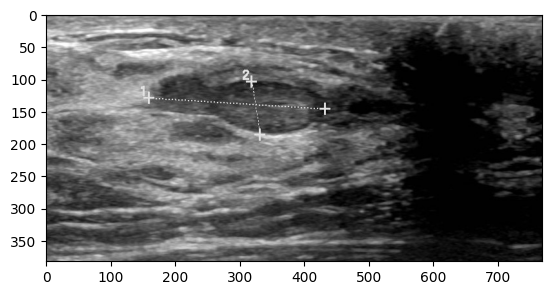

In [4]:
#첫 번째 원본 이미지 띄우기
from PIL import Image #PNG파일을 읽어들이기 위함

print(img_list[5])
file_img = img_list[5]
img = Image.open(file_img)
plt.imshow(img)

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (428)_mask.png


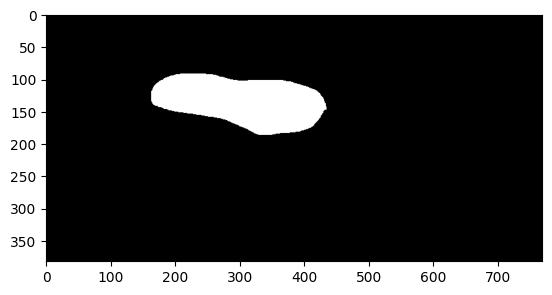

In [5]:
#첫 번째 mask image 띄우기
print(mask_list[5])
file_img = mask_list[5]
img = Image.open(file_img)
plt.imshow(img)

***Train&Test data Split***

In [6]:
#image set list와 mask set list를 함께 pairing한 다음, shuffle하는 코드
#shuffle 후, train과 test data를 split해준다

import random 
from sklearn.model_selection import train_test_split

random.seed(2023)

img_mask_tuples = list(zip(img_list, mask_list))

random.shuffle(img_mask_tuples)

train_tuples, test_tuples = train_test_split(img_mask_tuples, test_size=0.2)

In [7]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1 #gray scale로 묶는 function

X_train = np.zeros((len(train_tuples), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_tuples), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_test = np.zeros((len(test_tuples), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_tuples), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [8]:
from skimage.transform import resize

#X_train: 'channel수 =1' 변환을 위한 gray_scale 적용
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140]) #[R, G, B]의 가중치값

for i, image_id in enumerate(train_tuples): #enumerate를 사용하면, i는 숫자가 0부터 데이터수만큼 증가하게 되고, image_id에는 tuple값이 나타나게 된다
    #반복적으로 tuple에서 빼오는 구조...
    
    #read the image using skimage
    image = Image.open(image_id[0]) #0번째 원본 image를 빼온 후, 
    image_np = np.array(image)
    image_gray = rgb2gray(image_np) #gray scale로 변환
    
    #resize the image
    image = resize(image_gray, (IMG_HEIGHT, IMG_WIDTH)) #512x512로 reshape을 해줌
    
    #use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1) #image list가 쭉 들어가도록 하기 위해 첫 번쩨 Index에 해당하는 부분에 dimension을 하나 넣어줌. 
    
    #insert the image into X_train
    X_train[i] = image #X_train의 i index에 처리된 image를 넣어줌
    
    #read the image using cv2, and then convert RGB to gray scale
    mask = Image.open(image_id[1]) #tuple index 0내에 두 번째 file이름을 불러오면 그게 mask file인 것임. 
    mask = np.array(mask) # PngImageFile 객체를 numpy 배열로 변환
    mask = rgb2gray(mask) #불러온 후 gray scale로 변환해준다
    
    #resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    
    #use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1) #dimension하나를 넣어준 후, 
    
    #inset the image into Y_train
    Y_train[i] = (mask/255 >= 0.5).astype(int) #Y_train에 값을 넣어줬다
    
print(X_train.shape)
print(Y_train.shape)

(624, 512, 512, 1)
(624, 512, 512, 1)


==> X_train & Y_train:
* 원본 이미지는 초음파 사진으로, 이미 흑백 상태이기 때문에 rgb2gray를 해줄 필요가 없음!
* 원본 이미지와 mask image가 624개의 pair로 구성돼있음을 알 수 있다. 각각의 크기는 512x512이며 channel 수는 하나임을 알 수 있음. 

In [9]:
#X_test: test_tuples에 대해 input과 mask값을 나눠주게 됨
for i, image_id in enumerate(test_tuples): #위 cell과의 차이: 위에는 train_tuples, 여기는 test_tuples라는 점이 다름
    
    #read the image using skimage
    image = Image.open(image_id[0])
    image = np.array(image) # PngImageFile 객체를 numpy 배열로 변환
    image = rgb2gray(image)
    
    #resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    #use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    #insert the image into X_test
    X_test[i] = image
    
    #read the image using cv2, and then convert RGB to gray scale
    mask = Image.open(image_id[1])
    mask = np.array(mask) # PngImageFile 객체를 numpy 배열로 변환
    mask = rgb2gray(mask)
    
    #resize the image 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    
    #use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    #insert the image into Y_test
    Y_test[i] = (mask/255 >= 0.5).astype(int)
    
print(X_test.shape)
print(Y_test.shape)

(156, 512, 512, 1)
(156, 512, 512, 1)


==> 원본 이미지와 mask image pair 개수는 총 156개이며, 각각의 크기는 512x512, 그리고 channel 수는 한 개임을 알 수 있음

-- 이상. data 전처리와 train&test split까지 마쳤다 -- 

***Helper functions***

In [10]:
#Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32) # 데이터 타입 변환
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, (-1,))
    y_pred_f = tf.reshape(y_pred, (-1,))
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score
    
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)  # 데이터 타입 변환
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true,[1,2,3])+tf.reduce_sum(y_pred,[1,2,3])-intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1
    y_true = tf.cast(y_true, tf.float32)  # 데이터 타입 변환
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, (-1,))
    y_pred_f = tf.reshape(y_pred, (-1,))
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1.0 - score

def bce_dice_loss(y_true, y_pred): #여기서는 loss값들을 합친 값을 사용하게 됨. # loss function은 여러개의 조합으로 사용해줄 수 있다
    y_true = tf.cast(y_true, tf.float32)  # 데이터 타입 변환
    y_pred = tf.cast(y_pred, tf.float32)
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

: y_true와 y_pred를 따로 정의할 필요는 없음. 모델 훈련 및 평가 시 모델의 예측값과 실제값이 자동으로 y_pred와 y_true로 전달됨.

!!주의: 모델의 예측값과 실제값은 같은 형태(배열이나 텐서)를 가져야 함!!

***U-Net 구현***

In [11]:
#U-Net 구현

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

#축소경로 
    #BatchNormalization을 Convolution을 지날 때마다 추가해준다. 부족한 경우 segmentation이 잘 일어나지 않는 경향이 있음
    #과적합 방지를 위해 Dropout 또한 추가해준다
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1)(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1)(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2)(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2)(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

#확장경로
    #역시, BatchNormalization과 Dropout을 틈틈이 추가해준다
    #Conv2DTranspose를 이용해 합성곱 연산의 역연산을 수행한다
u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same') (c5)
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = Dropout(0.2)(c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2)(c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1)(c8)

u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1)(c9)

#확장경로가 끝난 후, 1x1 convolution을 사용해 mask값을 뽑아냄
outputs = Conv2D(1, (1,1), activation='sigmoid')(c9) #마지막 activation함수로 sigmoid를 사룡

model = Model(inputs=[inputs], outputs=[outputs])

optimizer = Adam(learning_rate = 0.001) #0.001로 했을 때 수렴이 잘 안돼고 학습이 잘 안돼서 파라미터값을 줄여봄. 혹 잘 안된다면 또 올려보던지 하기
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_coef, iou_coef]) #loss값으로 cross-entropy와 dice_coef_loss값을 합친 것을 사용

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        160 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[

 Total params: 1,842,577 (7.03 MB)

 Trainable params: 1,840,529 (7.02 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [12]:
#U-Net 구조 시각화: summary에서 발견하지 못한 문제점 발견하기 쉽다

from keras.utils import plot_model
from PIL import Image

plot_model(model, to_file='unet_model.png', show_shapes=True)
img = Image.open("unet_model.png")
img.show()

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

earlystopper = EarlyStopping(patience=5, verbose=1)

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

callbacks_list = [rlr_cb, ely_cb]

history = model.fit(X_train, Y_train, validation_split=0.1, 
                    batch_size=5, epochs=50, callbacks=callbacks_list) #batch_size와 epoch값을 많이 조정함

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmp55ti4we4.PNG'


Epoch 1/50


2024-05-26 11:45:49.522358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262388: 0.377577, expected 0.239651
2024-05-26 11:45:49.522419: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262422: 0.37737, expected 0.239444
2024-05-26 11:45:49.522437: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262655: 0.377078, expected 0.239152
2024-05-26 11:45:49.523044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 349183: 0.323218, expected 0.185292
2024-05-26 11:45:49.523765: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 471039: 0.351469, expected 0.213543
2024-05-26 11:45:49.523894: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 481279: 0.314954, expected 0.177028
2024-05-26 11:45:49.524251: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 524206: 0.359157, expected 0.221232
2024-05

  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:49:41 59s/step - dice_coef: 1.5804e-06 - iou_coef: 7.9467e-06 - loss: 1.9427

I0000 00:00:1716723980.133065     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - dice_coef: 1.6459e-06 - iou_coef: 8.2335e-06 - loss: 1.6809

2024-05-26 11:46:49.057706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.66215, expected 1.08363
2024-05-26 11:46:49.057765: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.7715, expected 1.19297
2024-05-26 11:46:49.057774: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.06056, expected 1.48203
2024-05-26 11:46:49.057782: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.17584, expected 1.59731
2024-05-26 11:46:49.057790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.67481, expected 1.09629
2024-05-26 11:46:49.057798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.19715, expected 1.61863
2024-05-26 11:46:49.057805: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.45827, expected 1.87974
2024-05-26 11:46:49.057813: E external/local_xla/xla/ser

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 1.6479e-06 - iou_coef: 8.2401e-06 - loss: 1.6801

2024-05-26 11:47:11.861484: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.90157, expected 1.40657
2024-05-26 11:47:11.861542: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.98515, expected 1.49015
2024-05-26 11:47:11.861559: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.22822, expected 1.73322
2024-05-26 11:47:11.861577: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.65875, expected 2.16374
2024-05-26 11:47:11.861592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.02553, expected 1.53052
2024-05-26 11:47:11.861603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.18479, expected 1.68979
2024-05-26 11:47:11.861617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.09672, expected 2.60171
2024-05-26 11:47:11.861627: E external/local_xla/xla/se

113/113 ━━━━━━━━━━━━━━━━━━━━ 115s 503ms/step - dice_coef: 1.6499e-06 - iou_coef: 8.2465e-06 - loss: 1.6793 - val_dice_coef: 1.4782e-06 - val_iou_coef: 8.7858e-06 - val_loss: 406.4761 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - dice_coef: 2.6331e-06 - iou_coef: 1.3153e-05 - loss: 1.3679 - val_dice_coef: 1.5717e-06 - val_iou_coef: 8.3784e-06 - val_loss: 12.9396 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - dice_coef: 5.8753e-06 - iou_coef: 2.9405e-05 - loss: 1.1530 - val_dice_coef: 1.6355e-05 - val_iou_coef: 1.8965e-04 - val_loss: 1.1604 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - dice_coef: 1.2451e-05 - iou_coef: 6.2626e-05 - loss: 1.0692 - val_dice_coef: 1.5445e-05 - val_iou_coef: 7.8184e-05 - val_loss: 1.0544 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - dice_coef: 2.3566e-05 - iou_coef: 1.1805e-04 - loss: 1.0349 - val_dice_coef: 4.1658e-05 - 

# 2. 모델 평가 (Dice Score 혹은 IoU 중 택 1)

***Learning Curves***

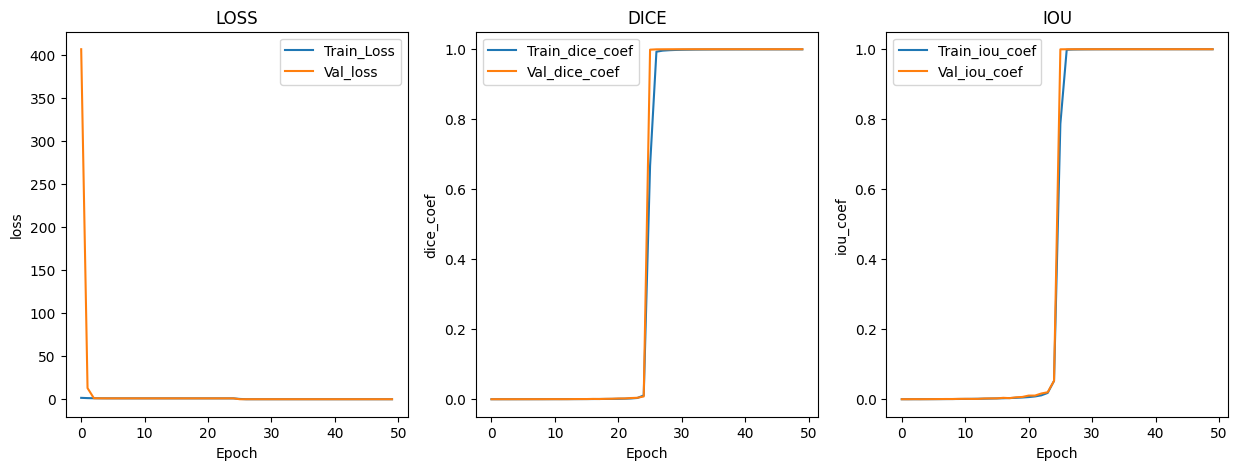

In [14]:
# History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

==> 
!["C:\Users\parkh\Downloads\epoch50 결과.png"](http://)
* 1차 시도: epoch 50으로 맞춤 - train과 validation의 trend는 매우 유사함을 알 수 있음. Early stopping을 넣었으나, epoch 50까지 학습이 끝까지 진행됐다. 
1. LOSS값은 epoch 5까지 기하급수적으로 줄다가 epoch 40까지는 거의 변화가 없음. epoch 40지점부터 급하강하여 0에 수렴하는 모습을 볼 수 있다. 
2. DICE(more Recall): f1-score와 같은 개념으로, 1에 가까울수록 모델의 민감도와 정밀도가 좋다. 반대로 0에 가까울수록 민감도 또는 정밀도가 안좋다는 뜻인데, epoch 40지점까지는 1.0값을 유지하다가 급하강하여 0에 수렴하는 모습을 볼 수 있다.; 이때는 1-score로 return되도록 설정되어 있었으므로, 정확도와 정밀도가 높은 상황으로 해석할 수 있음
3. IoU(same Recall and Precision): IoU는 DICE 수식의 TP에 x1/2해준 형태다. 역시 마찬가지로 1.0값을 유지할수록 모델의 민감도와 정밀도가 좋다는 의미로 해석할 수 있는데, IoU값은 DICE와 정반대되는 경향을 보이고 있다. 내내 0지점에 머물다가 정확히 DICE값이 하강하기 시작하는 epoch 40지점부터 급상승하여 학습이 끝날때는 1.0에 수렴하는 모습을 볼 수 있다.
> Q. 결과가 왜 이렇게 극단적으로 나온걸까?
>>: DICE계수는 IoU에 비해 약간 더 높은 값으로 계산된다. 두 지표는 서로 상호보완적이나, 같은 데이터에 대해서도 다르게 반응할 수 있다. 
>>1. 오버피팅 또는 언더피팅: 모델이 학습 도중 특정 지점에서 갑작스럽게 성능이 변화하는 것은 오버피팅 혹은 언더피팅의 징후일 수 있음. 
>>2. 불안정한 학습: 학습률이 너무 높거나, 데이터 불균형 등이 원인일 수 있음. 이 경우 학습이 불안정하게 진행되며, 특정 epoch에서 갑자기 성능이 변화할 수 있음. 
>>3. 지표의 민감도 차이: DICE계수와 IoU는 비슷하나, DICE계수가 민감도(Recall)에 더 민감하게 반응함. 반면, IoU는 정밀도(Precision)과 민감도를 균등하게 반영함. 따라서 모델이 민감도에 보다 집중적으로 학습됐다면, DICE 계수가 보다 극단적으로 변할 수 있음. 
민감도(Recall)=(TP/(TP+FN)), 정밀도(Precision)=(TP/(TP+FP))

* 2차 시도: LOSS갑과 DICE값은 초반에 점차 증가하다가 대략 epoch25부터 급상승하는 모습을 보인다. loss에서 validation값은 두 지점이 뛰는 경향을 보이고 있다. train loss값에는 거의 차이가 없다.

# 3. 원본, Ground Truth 마스크, 모델 분할 결과 예시(1건 이상) 출력

In [15]:
#test data를 통해 분할 성능 살피기

#Make a prediction
test_preds = model.predict(X_test) #맨끝에서 sigmoid를 취한값만 나오게 된다.

#Threshold the prediction 
    #0.5를 기준으로 이하냐, 이상이냐에 따라 pixel별로 분류, #'preds_test_thresh'에서는 최종적으로 mask결과값이 된다.
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8) #sigmoid값을 0 or 1로 정확히 분류하기 위한 코드    

2024-05-26 11:57:47.317066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.20762, expected 0.794404
2024-05-26 11:57:47.317124: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.96783, expected 1.55461
2024-05-26 11:57:47.317139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.78633, expected 1.37312
2024-05-26 11:57:47.317156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.13183, expected 1.71861
2024-05-26 11:57:47.317176: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.96516, expected 1.55195
2024-05-26 11:57:47.317189: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.87759, expected 1.46438
2024-05-26 11:57:47.317199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.24484, expected 1.83163
2024-05-26 11:57:47.317210: E external/local_xla/xla/s

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

2024-05-26 11:58:16.875734: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.25708, expected 1.42702
2024-05-26 11:58:16.875784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.46605, expected 1.63599
2024-05-26 11:58:16.875794: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.99973, expected 2.16968
2024-05-26 11:58:16.875802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.86955, expected 2.0395
2024-05-26 11:58:16.875810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.29721, expected 1.46715
2024-05-26 11:58:16.875818: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.32352, expected 2.49347
2024-05-26 11:58:16.875826: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.54946, expected 2.7194
2024-05-26 11:58:16.875834: E external/local_xla/xla/serv

5/5 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step 


Sample 0: test_image min=0, max=212
Sample 0: true_mask min=0, max=0
Sample 0: test_mask min=0, max=0
Sample 1: test_image min=0, max=254
Sample 1: true_mask min=0, max=0
Sample 1: test_mask min=0, max=0
Sample 2: test_image min=0, max=254
Sample 2: true_mask min=0, max=0
Sample 2: test_mask min=0, max=0
Sample 3: test_image min=0, max=231
Sample 3: true_mask min=0, max=0
Sample 3: test_mask min=0, max=0
Sample 4: test_image min=0, max=253
Sample 4: true_mask min=0, max=0
Sample 4: test_mask min=0, max=0
Sample 5: test_image min=0, max=254
Sample 5: true_mask min=0, max=0
Sample 5: test_mask min=0, max=0
Sample 6: test_image min=0, max=254
Sample 6: true_mask min=0, max=0
Sample 6: test_mask min=0, max=0
Sample 7: test_image min=10, max=236
Sample 7: true_mask min=0, max=0
Sample 7: test_mask min=0, max=0
Sample 8: test_image min=0, max=254
Sample 8: true_mask min=0, max=0
Sample 8: test_mask min=0, max=0
Sample 9: test_image min=0, max=224
Sample 9: true_mask min=0, max=0
Sample 9: te

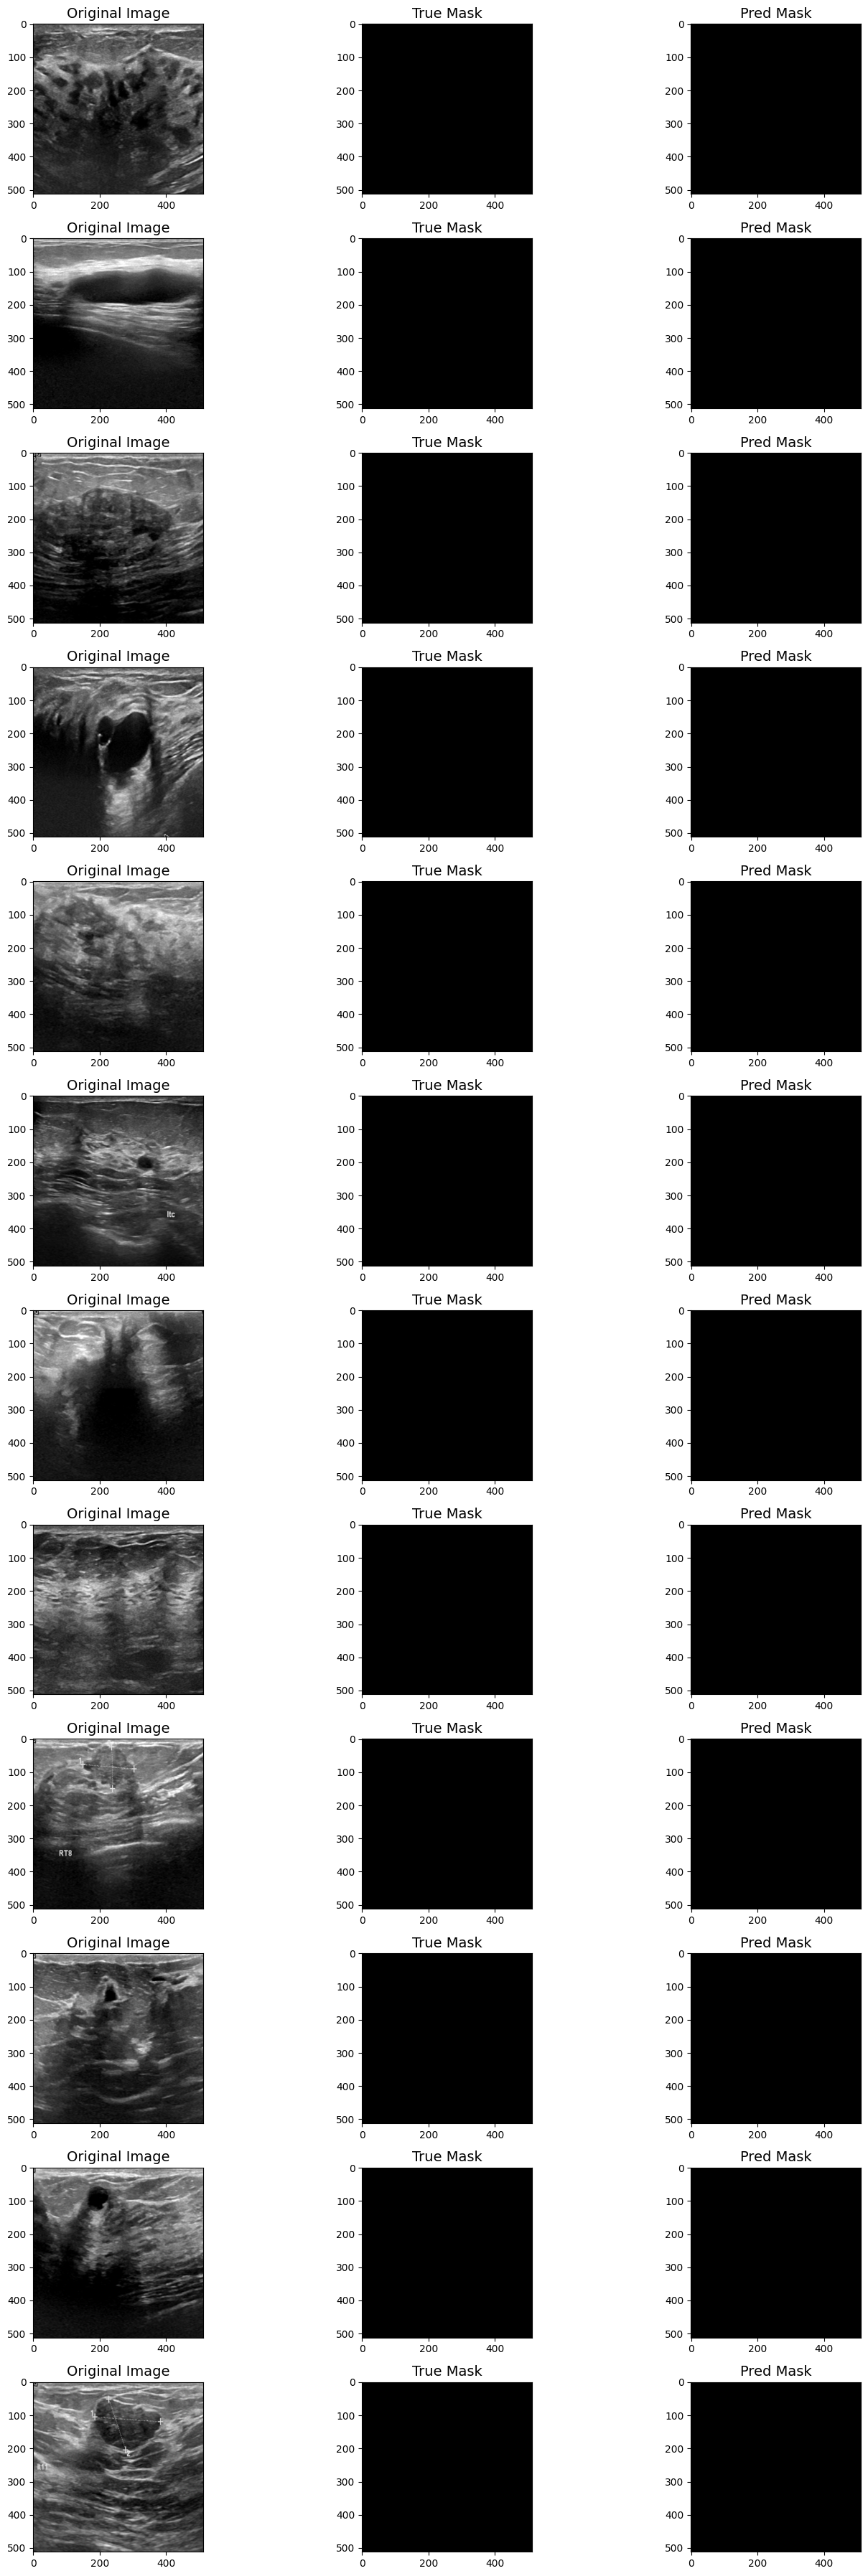

In [16]:
#출력시도
    #원본 이미지와 ground truth, U-Net이 학습을 마친 후 testdata에서 어떻게 prediction하는지 살펴본다.

import matplotlib.pyplot as plt

# 시각화할 샘플의 수 제한 (최대 12개 샘플 시각화)
num_samples = min(len(X_test), 12)

plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    # 원본 이미지
    plt.subplot(num_samples, 3, i * 3 + 1)
    test_image = X_test[i, :, :, 0]
    plt.imshow(test_image, cmap='gray')
    plt.title('Original Image', fontsize=14)

    # 실제 마스크
    plt.subplot(num_samples, 3, i * 3 + 2)
    true_mask = Y_test[i, :, :, 0] * 255
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask', fontsize=14)

    # 예측 마스크
    plt.subplot(num_samples, 3, i * 3 + 3)
    test_mask = preds_test_thresh[i, :, :, 0] * 255
    plt.imshow(test_mask, cmap='gray')
    plt.title('Pred Mask', fontsize=14)

    # 디버깅 출력
    print(f"Sample {i}: test_image min={test_image.min()}, max={test_image.max()}")
    print(f"Sample {i}: true_mask min={true_mask.min()}, max={true_mask.max()}")
    print(f"Sample {i}: test_mask min={test_mask.min()}, max={test_mask.max()}")
    
plt.tight_layout()
plt.show()

In [17]:
#점검
#데이터 전처리 확인
print(f"X_train shape: {X_train.shape}, min: {X_train.min()}, max: {X_train.max()}")
print(f"Y_train shape: {Y_train.shape}, min: {Y_train.min()}, max: {Y_train.max()}")
print(f"X_test shape: {X_test.shape}, min: {X_test.min()}, max: {X_test.max()}")
print(f"Y_test shape: {Y_test.shape}, min: {Y_test.min()}, max: {Y_test.max()}")

X_train shape: (624, 512, 512, 1), min: 0, max: 254
Y_train shape: (624, 512, 512, 1), min: 0, max: 0
X_test shape: (156, 512, 512, 1), min: 0, max: 254
Y_test shape: (156, 512, 512, 1), min: 0, max: 0


In [18]:
#모델 예측 확인
preds_test = model.predict(X_test)
print(f"preds_test shape: {preds_test.shape}, min: {preds_test.min()}, max: {preds_test.max()}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
preds_test shape: (156, 512, 512, 1), min: 6.697924766901897e-12, max: 1.6724729240413794e-11


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


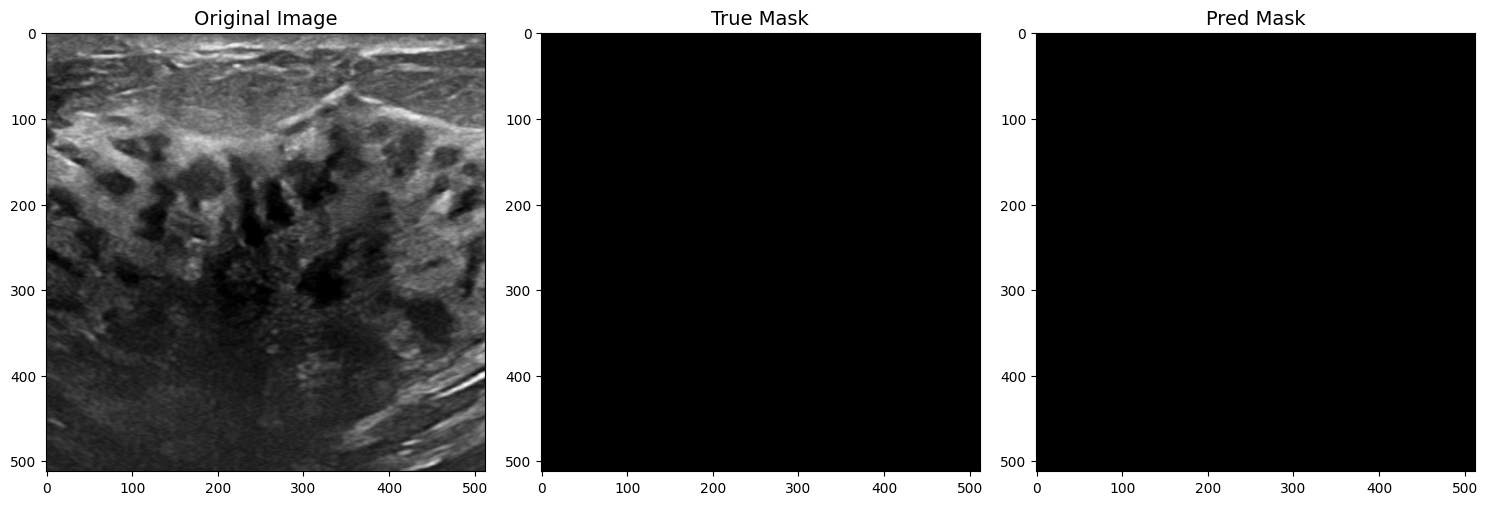

In [19]:
#샘플데이터 확인
import matplotlib.pyplot as plt

# 테스트 데이터의 첫 번째 샘플 시각화
plt.figure(figsize=(15, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.imshow(X_test[0, :, :, 0], cmap='gray')
plt.title('Original Image', fontsize=14)

# 실제 마스크
plt.subplot(1, 3, 2)
plt.imshow(Y_test[0, :, :, 0] * 255, cmap='gray')
plt.title('True Mask', fontsize=14)

# 예측 마스크
plt.subplot(1, 3, 3)
pred_mask = (model.predict(X_test[0:1])[0, :, :, 0] > 0.5).astype(np.uint8) * 255
plt.imshow(pred_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)

plt.tight_layout()
plt.show()